Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [19]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [20]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [21]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [22]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [23]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'originated', 'a', 'term', 'originated', 'as', 'of', 'term']


Train a skip-gram model.

In [24]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [25]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.551125
Nearest to many: stallone, indulgence, camden, picket, thinly, lump, paperbacks, charlotte,
Nearest to nine: pellets, sanity, alexandrovich, quantity, biggest, hanns, secretariat, gills,
Nearest to up: soil, zarqawi, dtv, plunged, machete, malvales, efficiencies, christensen,
Nearest to a: gees, hanged, overcrowded, birthdate, deviate, babe, documentaries, quantum,
Nearest to that: randomized, backups, brasses, vulpes, ichthyology, accidentals, monopolistic, patriot,
Nearest to than: limited, harpoon, sloan, sociologist, coral, tissues, synthesize, fisher,
Nearest to when: amos, contemplating, heats, improper, ptc, insecurity, ech, coru,
Nearest to if: devo, perfectly, merovingian, ventured, offutt, camels, headless, summon,
Nearest to about: liberals, deteriorated, finger, twain, scabbard, cyrix, durability, howls,
Nearest to first: jeeps, scathing, dispersal, compl, claudius, dynamo, advantages, geisel,
Nearest to known: casablanca, descri

Average loss at step 52000: 3.441770
Average loss at step 54000: 3.426368
Average loss at step 56000: 3.440197
Average loss at step 58000: 3.395964
Average loss at step 60000: 3.391798
Nearest to many: some, several, various, these, most, those, other, all,
Nearest to nine: eight, six, seven, four, five, three, zero, one,
Nearest to up: out, off, them, down, him, back, soil, plunged,
Nearest to a: the, another, any, scant, every, problematic, no, htp,
Nearest to that: which, what, ichthyology, it, svenska, this, however, who,
Nearest to than: but, or, sporting, and, morita, recruiting, attention, efficient,
Nearest to when: if, although, after, while, where, because, before, since,
Nearest to if: when, where, though, since, so, although, curtiss, then,
Nearest to about: vannevar, on, grows, chant, computationally, insurrections, zwickau, fiery,
Nearest to first: second, last, third, next, best, final, jeeps, only,
Nearest to known: used, such, possible, considered, well, defined, refer

In [26]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

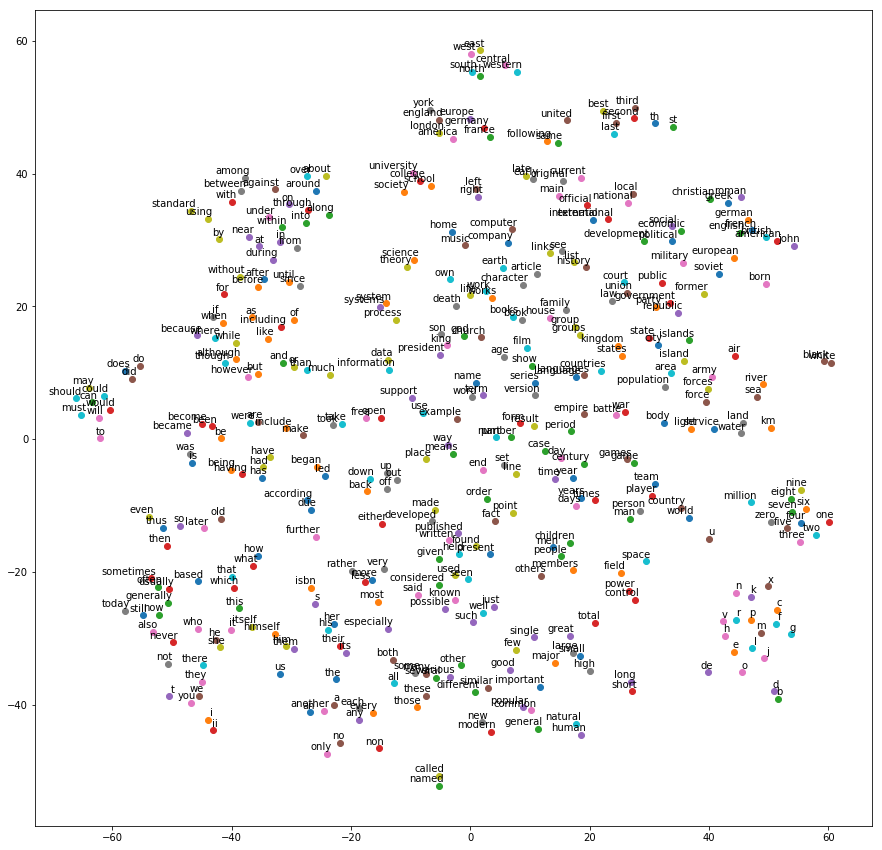

In [27]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [12]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

url = 'http://mattmahoney.net/dc/'


def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)  # 远程下载数据
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename


filename = maybe_download('text8.zip', 31344016)


# Read the data into a string.

def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


words = read_data(filename)  # return a string
print('Data size %d' % len(words))



Found and verified text8.zip
Data size 17005207


* 建立dictionary，以word出现次数作为word编码

In [13]:
# Build the dictionary and replace rare words with UNK token.

vocabulary_size = 50000


def build_dataset(words):
    count = [['UNK', -1]]  # UNK: unknown word in Tensorflow; 由于 'UNK'对应出现次数后面要赋值，故这里用list，不用tuple.
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))  # 返回words中，top 49999多的words及其出现次数
    dictionary = dict()
    for word, _ in count:  # 词按出现频率由高到低的顺序，依次iterate
        dictionary[word] = len(dictionary)  # dictioanry 中 value说明了word 频率的名次, dictionary 中, word都在 .key中，是按words统计时的顺序排列
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]  # word同时出现在 words 和 dictioanry中（即word在出现频率为 Top 49999的词的集合中）
        else:
            index = 0  # dictionary['UNK'] # 出现频率较低的words，index = 0，都统计为 UNK
            unk_count = unk_count + 1
        data.append(index)  # data记录了原文中（words）,依次出现的词的出现频率的名次
    count[0][1] = unk_count        # count[0] = ['UNK', 418391], 即 count[0]记录了 UNK的个数，count[i] 记录了 第i多的word的个数
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

# data: 原文中，依次出现的words的出现次数；出现次数按高到低排名超过49999的，word都记为UNK，排名为0
# count: 每个元素格式为 ('word', #出现次数)，元素按出现次数从大到小排列('UNK'无论出现次数多少都排在第一，即：count[0] = ['UNK',418391], count[1] = ('the',1061396))
# dictionary: key: word, value: 出现次数的排名（是对count的一个处理）
# reverse_dictionary: key: 出现次数的排名； key: word. (key按数字由小到大排列，是对dictionary的一个处理）


data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.


Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


* 为CBOW模型生成training batch

In [14]:
# Function to generate a training batch for the CBOW model.
data_index = 0

def generate_batch(batch_size, skip_window):  # batch_size: the size of a batch of sample data.
  global data_index
  assert batch_size % skip_window == 0    # batch_size中应当有整数个skips
  assert batch_size >=2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)   #随机生成的一个array, shape为(batch_size,)
  labels = np.ndarray(shape=(batch_size//(2*skip_window), 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span) #buffer是一个bounded 双向队列，长度上限是span
  context = 2 * skip_window
#  batch_size = batch_size * context # 因为CBOW预测一个词时需要上下文内所有的词，因此要到达实际有效的batch，处理时生成的batch_size是设定的batch_size的一个整数倍

  # buffer 一次读进数量为 span的words.
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)  #求余数
  for i in range(batch_size// context):
    target = skip_window  # target label at the center of buffer (length of a span). 因为buffer的长度是始终是 2*skip_window + 1
    for j in range(context):
        labels[i , 0] = buffer[target]
        if j >= skip_window:
            batch[i * context + j] = buffer[j + 1]
        else:
            batch[i * context + j] = buffer[j]
    buffer.append(data[data_index])   # batch中填入了 num_skips的words之后，buffer中就加入一个新的word，同时将最左边的元素弹出
    data_index = (data_index + 1) % len(data)
  return batch, labels


print('data:', [reverse_dictionary[di] for di in data[:8]])

# 打印skip_window = 1, 2 的两个batch的例子。
for skip_window in [1,2]:
    data_index = 0
    batch_size = 8
    batch, labels = generate_batch(batch_size=batch_size, skip_window=skip_window)
    print('\nskip_window = %d:' % (skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size//(2*skip_window))])



data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

skip_window = 1:
    batch: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'a', 'of']
    labels: ['originated', 'as', 'a', 'term']

skip_window = 2:
    batch: ['anarchism', 'originated', 'a', 'term', 'originated', 'as', 'term', 'of']
    labels: ['as', 'a']


In [17]:
batch_size = 512
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 2 # How many words to consider left and right.
context = 2*skip_window

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size)) #shape: (16,)，从 [0,99]中不放回随机取16个，之后作为index集合
num_sampled = 64 # Number of negative examples to sample.


graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])  #shape = (128,)
    train_labels = tf.placeholder(tf.int32, shape=[batch_size//context, 1])  # shape = (128/2,1)
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)  #shape = (16,)

    # Variables.
    embeddings = tf.Variable(  # shape = (50000,128)
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))  # 词典中words的数量为vocabulary_size，每个词用长度为 embedding_size的向量来表示。
        # 随机得到的张量的shape由第一个参数指定，每个元素由[-1,1)之间均匀分布得到
    softmax_weights = tf.Variable(   # shape = (50000,128)
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size])) #shape = (50000,)
    # embed 通过一个 softmax 分类器，这是一个线性函数 WX+b，W,b由这里的softmax_weights, softmax_biases给出
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)   # shape: (128, 128)
    m, n = embed.shape   # m: 是 batch_size, n是 embedding 向量维度
    embed = tf.reshape(embed,shape = (m//context,context, n))
    embed = tf.reduce_sum(embed, axis = 1)/context # shape = (m//context, n) 因为一个word需要context数量的words的输入

    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                   labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:

    # embeddings shape: (50000, 128), 50000 words in vocabulary, 128 features.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))    # norm shape: (50000, 1), 每个行向量都是一个 embedding向量元素的平方和。
    normalized_embeddings = embeddings / norm   # shape为(50000,128)和 (50000,1)的两个向量的division，结果shape = (50000,128) 是embeddings的每个行向量除上norm的每个行向量。
    valid_embeddings = tf.nn.embedding_lookup(  # shape = (16,128)
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) # shape = (16, 50000)


num_steps = 100001


with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)  # 运行 optimizer()
    # average_loss += l
    # if step % 2000 == 0:
    #   if step > 0:
    #     average_loss = average_loss / 2000
    #   # The average loss is an estimate of the loss over the last 2000 batches.
    #   print('Average loss at step %d: %f' % (step, average_loss))
    #   average_loss = 0
    # # note that this is expensive (~20% slowdown if computed every 500 steps)
    # if step % 10000 == 0:
    #   sim = similarity.eval()
    #   for i in range(valid_size):
    #     valid_word = reverse_dictionary[valid_examples[i]]  # 出现次数的名次为valid_example[i]的word
    #     top_k = 8 # number of nearest neighbors
    #     nearest = (-sim[i, :]).argsort()[1:top_k+1] # 返回的列表包含与valid_word相似度最高的top_k个words的相似度按从高到低在sim[i]中的indices.
    #     log = 'Nearest to %s:' % valid_word
    #     for k in range(top_k):  # 按相似度从高到低依次输出words.
    #       close_word = reverse_dictionary[nearest[k]]
    #       log = '%s %s,' % (log, close_word)
    #     print(log)
  print('optimize finished')
  final_embeddings = normalized_embeddings.eval()   # shape (50000,128)




Initialized
optimize finished


* 用TSNE对出现次数最多的400个词的embedding 向量降到2维，并显示出来。

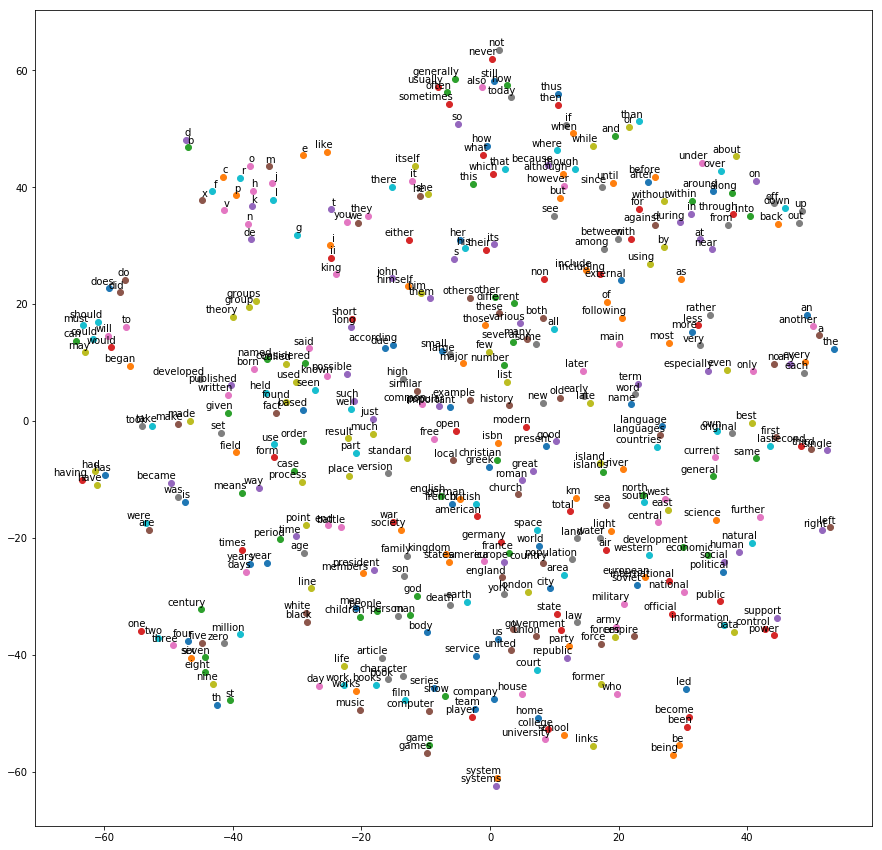

In [18]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact') # 定义一个 tsne实例
# 对数据 final_embeddings中 1-400 这400个词的embedding向量进行降维
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])   # shape (400, 2)


def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]  # x: 第i个word, y: 对应的降维后的向量
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()


words = [reverse_dictionary[i] for i in range(1, num_points+1)] # 提取前400名的words
plot(two_d_embeddings, words)